## Clustering Model: Model with Product Category

Set up a basic pipeline using **standardized preprocessing from preprocess.py** and distilbert.

## 🔧 Steps:
1. Import Libraries and load data using **preprocess.py functions**
2. Preprocessing: refer data_preprocessing.ipynb notebook
3. Vectorization: TF-IDF Vectorization
4. Model: K-Means clustering on Review
5. Evaluation: Clustering

##  ✅ Purpose:
Establish a working pipeline using **standardized preprocessing functions** and maintain baseline score (~70-80% accuracy expected).

## Load Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mercy\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Step 1: Load the Cleaned data

In [2]:
df = pd.read_csv('data/cleaned_amazon_reviews_final.csv')
print(df.head())
print(df.info())

                                                name       asins   brand  \
0  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
1  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
2  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
3  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   
4  Amazon Kindle E-Reader 6" Wifi (8th Generation...  B00ZV9PXP2  Amazon   

                                          categories primaryCategories  \
0  Computers,Electronics Features,Tablets,Electro...       Electronics   
1  Computers,Electronics Features,Tablets,Electro...       Electronics   
2  Computers,Electronics Features,Tablets,Electro...       Electronics   
3  Computers,Electronics Features,Tablets,Electro...       Electronics   
4  Computers,Electronics Features,Tablets,Electro...       Electronics   

                                           imageURLs  doRecommend  rating  \
0  https://pisces.bby

## Step 2: Preprocess and Vectorize text using TF-IDF

In [14]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7, min_df=5)
X = vectorizer.fit_transform(df['clean_text'])
print(f"TF-IDF Matrix Shape: {X.shape}")

TF-IDF Matrix Shape: (4385, 1216)


## Step 3: K-Means Elbow Method

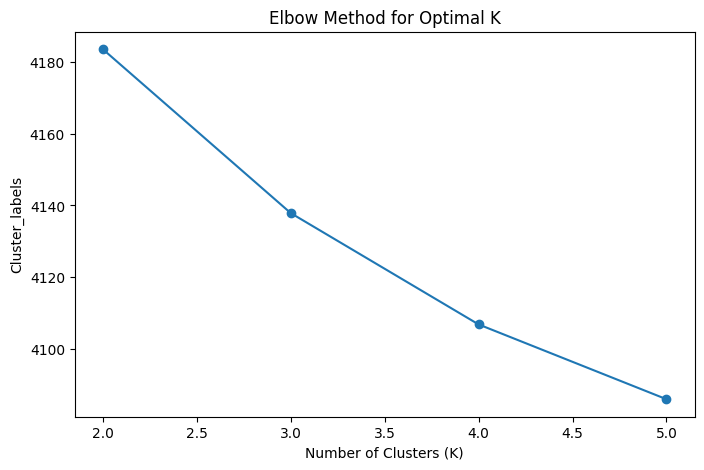

In [8]:
Cluster_labels = []  
k_values = range(2, 6) 

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    Cluster_labels.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_values, Cluster_labels, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Cluster_labels')
plt.show()

## Step 4: K-Means Silhouette Score

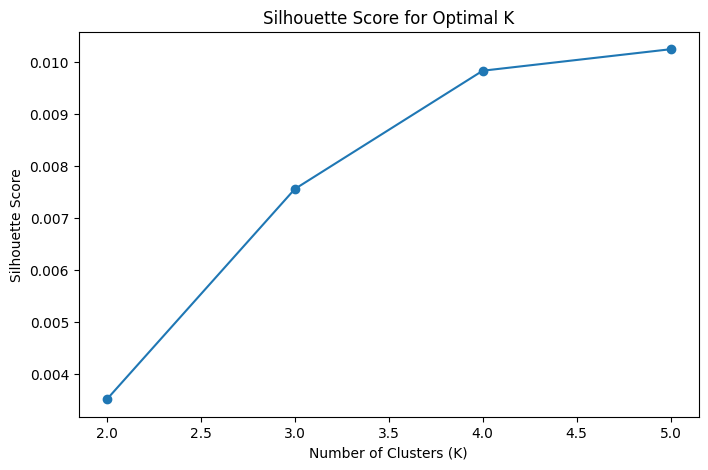

In [9]:
silhouette_scores = []
valid_k = []
for k in k_values:
    if k == 1:
        continue  # Silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    silhouette_avg = silhouette_score(X, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    valid_k.append(k)

plt.figure(figsize=(8, 5))
plt.plot(valid_k, silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

 ## Step 5: K-Means Clustering

cluster
1    1649
2     932
0     856
3     565
4     383
Name: count, dtype: int64


C:\Users\Mercy\AppData\Local\Temp\ipykernel_11684\4164717246.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='viridis')


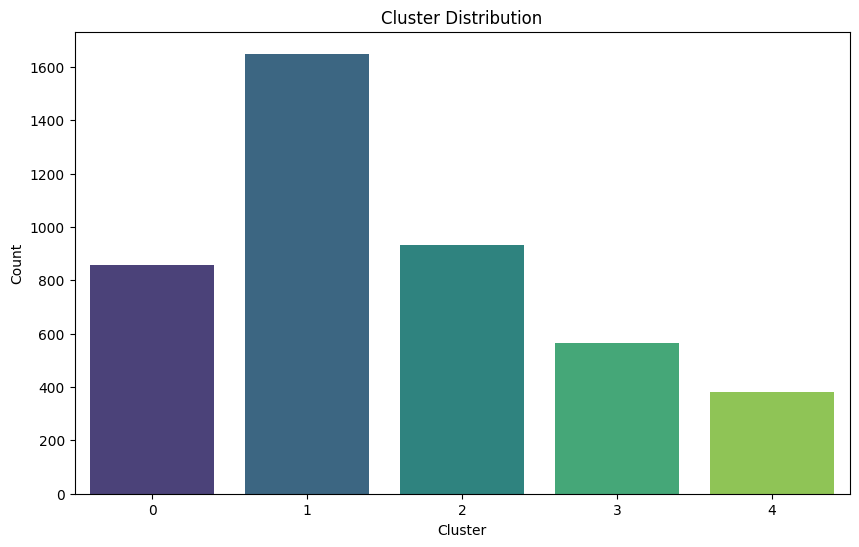

In [15]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X)
df['cluster'] = kmeans.labels_
print(df['cluster'].value_counts())
plt.figure(figsize=(10, 6))
sns.countplot(x='cluster', data=df, palette='viridis')
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.show()

In [ ]:
# Top Words per Cluster
def get_top_terms_per_cluster(kmeans_model, vectorizer, n_terms=10):
    terms = vectorizer.get_feature_names_out()
    top_words = {}
    for i, center in enumerate(kmeans_model.cluster_centers_):
        top_indices = center.argsort()[::-1][:n_terms]
        top_words[i] = [terms[i] for i in top_indices]
    return top_words

In [17]:
from collections import Counter

def top_words_by_cluster(df, cluster_col='cluster', text_col='clean_text', top_n=10):
    cluster_words = {}
    for c in sorted(df[cluster_col].unique()):
        words = ' '.join(df[df[cluster_col] == c][text_col]).split()
        common = Counter(words).most_common(top_n)
        cluster_words[c] = [word for word, _ in common]
    return cluster_words

top_words = top_words_by_cluster(df)
for cluster_id, words in top_words.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")

Cluster 0: tablet, great, kid, love, use, good, price, app, amazon, easi
Cluster 1: great, love, use, bought, easi, good, tablet, gift, work, kid
Cluster 2: echo, alexa, great, love, use, show, amazon, music, devic, sound
Cluster 3: kindl, read, great, love, book, fire, use, one, easi, light
Cluster 4: product, great, use, good, love, easi, price, work, recommend, tablet


## Step 6: Analyze Clusters

In [83]:
# Count the number of products in each cluster
cluster_counts = df['cluster'].value_counts().sort_index()
print(cluster_counts)

# Display sample products from each cluster
for cluster_id in range(optimal_k):
    print(f"Cluster {cluster_id}:")
    print(df[df['cluster'] == cluster_id]['name'].sample(3))  # Display 3 random samples
    print("\n")

cluster
0     519
1     751
2     783
3     590
4     371
5     275
6     225
7      81
8     107
9      96
10     96
11     24
12    178
13     67
14     22
15     47
16     28
17     21
18     44
19     22
20      4
21     22
22     12
Name: count, dtype: int64
Cluster 0:
2058    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
2736    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
2538    Fire Kids Edition Tablet, 7 Display, Wi-Fi, 16...
Name: name, dtype: object


Cluster 1:
366    Amazon Echo Show Alexa-enabled Bluetooth Speak...
549    Amazon Echo Show Alexa-enabled Bluetooth Speak...
575    Amazon Echo Show Alexa-enabled Bluetooth Speak...
Name: name, dtype: object


Cluster 2:
3485    All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...
3538    All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...
3182    All-New Fire HD 8 Tablet, 8" HD Display, Wi-Fi...
Name: name, dtype: object


Cluster 3:
1379    Amazon - Echo Plus w/ Built-In Hub - Silver
1201    Amazon - Echo Plus w/ Built-I

## Step 7: Visualize Clusters

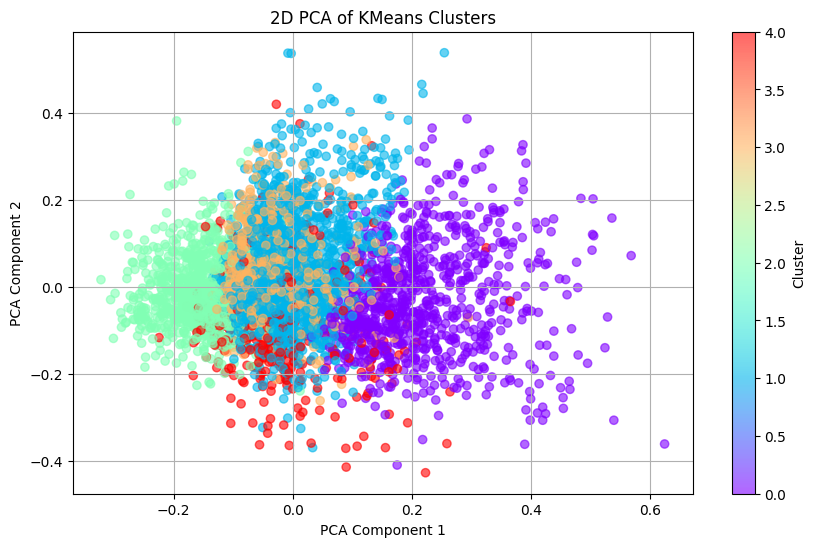

In [20]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
pca = PCA(n_components=2)
reduced = pca.fit_transform(X.toarray())

plt.figure(figsize=(10, 6))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.6)
plt.title('2D PCA of KMeans Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Cluster')
plt.grid(True)
plt.show()

C:\Users\Mercy\AppData\Local\Temp\ipykernel_11684\3984524002.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster', data=df, palette='Set2')


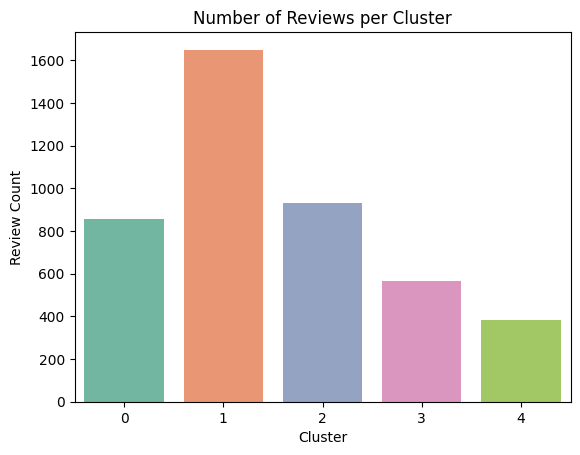

In [21]:
import seaborn as sns

sns.countplot(x='cluster', data=df, palette='Set2')
plt.title('Number of Reviews per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Review Count')
plt.show()

## Step 8: Identify 5 Best products

5 Best products

In [22]:
sorted_df = df.sort_values(by=["rating", "text"], ascending=[False, False])
unique_best = sorted_df.drop_duplicates(subset="name", keep="first")
best_products = unique_best.head(5)

In [25]:
for _, row in best_products.iterrows():
    print(f"Image URL: {row['imageURLs']}")
    print(f"Product Name: {row['name']}")
    print(f"Review: {row['clean_text']}")
    print(f"Rating: {row['rating']}")
    print(f"Primary Categories: {row['primaryCategories']}")
    print("-" * 40)

def process_review(image_url, review, rating):
    print(f"Processing: {image_url}, {review}, {rating}")

Image URL: http://i.ebayimg.com/thumbs/images/g/3MIAAOSwol5Y4W6z/s-l96.jpg,https://pisces.bbystatic.com/image2/BestBuy_US/images/products/5023/5023200_sa.jpg,http://i.ebayimg.com/thumbs/images/g/amcAAOSw6ShZSpke/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/PJgAAOSwiDFYPE8h/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/TPQAAOSwHb9Zcih6/s-l96.jpg,https://pisces.bbystatic.com/image2/BestBuy_US/images/products/5023/5023200_sd.jpg,http://i.ebayimg.com/thumbs/images/g/J4EAAOSw4CFYnSS8/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/LFQAAOSw1BlZWfTe/s-l200.jpg,http://images.frys.com/art/product/box_shots/8819902.box.GIF,http://i.ebayimg.com/thumbs/images/g/KO8AAOSw8GtZUbHj/s-l200.jpg,http://i.ebayimg.com/images/g/wv8AAOSw0W1ZjNVZ/s-l64.jpg,http://i.ebayimg.com/thumbs/images/g/I6UAAOSw-0xYc7VD/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/TPQAAOSwHb9Zcih6/s-l200.jpg,http://i.ebayimg.com/thumbs/images/g/fIMAAOSwlMFZN7Zq/s-l200.jpg,http://i.ebayimg.com/images/g/sVAAAOSwH6tZjNVW/s-l64.jpg,

Worst Product

In [26]:
from IPython.display import Image, display

worst_product = df.sort_values(by='label', ascending=True).head(1)

print("\nWorst Product:")
for index, row in worst_product.iterrows():
    #display(Image(url=url, width=100, height=100))
    print(f"Image URL: {row['imageURLs']}")
    print(f"Product Name: {row['name']}")
    print(f"Review: {row['clean_text']}")
    print(f"Rating: {row['rating']}")
    print(f"Primary Categories: {row['primaryCategories']}")
    print("-" * 40)

def process_review(image_url, review, rating):
    print(f"Processing: {image_url}, {review}, {rating}")


Worst Product:
Image URL: https://static.bhphoto.com/images/images500x500/amazon_b010cehqtg_echo_show_white_1502460407000_1353417.jpg,https://c1.neweggimages.com/NeweggImage/ProductImage/81-511-001-V01.jpg,https://i5.walmartimages.com/asr/5638a5f1-ac87-4f19-a40a-1c8f97667060_1.eb5a3b378540fee9c3df5c656a718cd9.jpeg%252525253FodnHeight%252525253D450%2525252526odnWidth%252525253D450%2525252526odnBg%252525253DFFFFFF,https://i5.walmartimages.com/asr/db02a974-11af-4de9-b228-c36426eb2b44_1.22c5de2dd319a4ae3a2f23548c464eb1.jpeg%252525253FodnHeight%252525253D450%2525252526odnWidth%252525253D450%2525252526odnBg%252525253DFFFFFF,https://static.bhphoto.com/images/images500x500/amazon_echo_show_2_pack_white_1506004002000_1353763.jpg,https://www.barcodable.com/images/barcode/0848719084894.png,https://c1.neweggimages.com/NeweggImage/ProductImage/81-511-001-V02.jpg,https://c1.neweggimages.com/NeweggImage/ProductImage/81-511-001-Z01.jpg,https://images-na.ssl-images-amazon.com/images/I/51YHTHvHapL.jpg,